# Weighted Mean Squared Error

In this notebook, we compare the differences for neural networks predictions for the entire BASS/MzLS footprint when training was performed with various cost functions.    
1. Case 1: No weight $$ J = \sum_{i} (n_{\rm gal, i} - f_{{\rm pix}, i}Y(x_{i}|\theta))^{2}$$     
2. Case 2: Weighted $$ J = \sum_{i} f_{{\rm pix}, i}(n_{\rm gal, i} - f_{{\rm pix}, i}Y(x_{i}|\theta))^{2}$$     

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import fitsio as ft
import sys
sys.path.append('/users/PHS0336/medirz90/github/LSSutils')
from lssutils.utils import make_hp
from lssutils.stats.cl import get_cl
import numpy as np
from lssutils.dataviz import setup_color
from lssutils.stats.nnbar import MeanDensity

def run_nbar(*arrays, **kwargs):
    nb = MeanDensity(*arrays, **kwargs)
    nb.run()
    return (nb.output['bin_avg'], nb.output['nnbar'], nb.output['nnbar_err'])

In [2]:
setup_color()

In [3]:
df = ft.read('/fs/ess/PHS0336/data/rongpu/imaging_sys/tables/v3/nlrg_features_bmzls_256.fits')

ns = 256
ng = make_hp(ns, df['hpix'], df['label'])
nr = make_hp(ns, df['hpix'], df['fracgood'])
ms = make_hp(ns, df['hpix'], 1.0) > 0.5
ebv = make_hp(ns, df['hpix'], df['features'][:, 0])

wnn = ft.read('/fs/ess/PHS0336/data/rongpu/imaging_sys/regression/v3/sv3nn_lrg_bmzls_256/nn-weights.fits')
wnnf = ft.read('/fs/ess/PHS0336/data/rongpu/imaging_sys/regression/v3/sv3nn_lrg_bmzls_256wfpix/nn-weights.fits')

In [4]:
nb_data = run_nbar(ng, nr, ms, ebv)
nb_models = {'no weight':[],
             'weighted':[]}
for i in range(20):
    w_ = make_hp(ns, wnn['hpix'], wnn['weight'][:, i])
    w_ = w_ / np.median(w_[ms])
    w_ = w_.clip(0.5, 2.0)      
    nb_ = run_nbar(w_*nr, nr, ms, ebv)
    nb_models['no weight'].append(nb_)
    
    w_f = make_hp(ns, wnnf['hpix'], wnnf['weight'][:, i])
    w_f = w_f / np.median(w_f[ms])
    w_f = w_f.clip(0.5, 2.0)      
    nb_f = run_nbar(w_f*nr, nr, ms, ebv)
    nb_models['weighted'].append(nb_f)
    print('.', end='')

....................

In [5]:
cl_data = get_cl(ng, nr, ms, njack=0)
cl_mitig = {'no weight':[],
            'weighted':[]}

for i in range(20):
    w_ = make_hp(ns, wnn['hpix'], wnn['weight'][:, i])
    w_ = w_ / np.median(w_[ms])
    w_ = w_.clip(0.5, 2.0)    
    cl_m = get_cl(ng, nr, ms, selection_fn=w_, njack=0)
    cl_mitig['no weight'].append(cl_m['cl_gg']['cl'])
    
    w_f = make_hp(ns, wnnf['hpix'], wnnf['weight'][:, i])
    w_f = w_f / np.median(w_f[ms])
    w_f = w_f.clip(0.5, 2.0)    
    cl_mf = get_cl(ng, nr, ms, selection_fn=w_f, njack=0)
    cl_mitig['weighted'].append(cl_mf['cl_gg']['cl'])
    print('.', end='')

....................

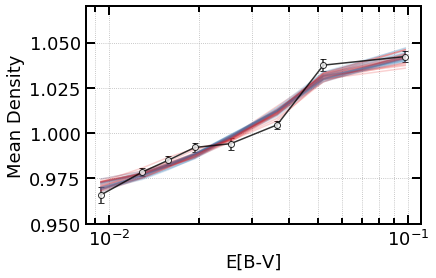

In [6]:
fg, ax = plt.subplots()


ax.errorbar(*nb_data, capsize=3, marker='o', mfc='w', alpha=0.8)

for i in range(20):
    
    ax.plot(*nb_models['no weight'][i][:-1], color='C1', ls='-', alpha=0.2)
    ax.plot(*nb_models['weighted'][i][:-1], color='C2', ls='-', alpha=0.2)
    
ax.set(xscale='log', ylim=(0.95, 1.07), ylabel='Mean Density', xlabel='E[B-V]')
ax.grid(ls=':', which='both')

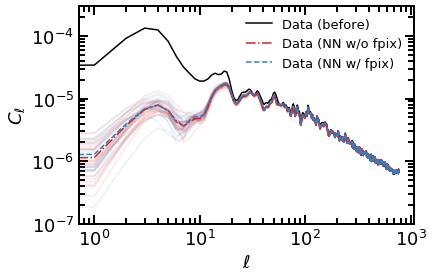

In [7]:
fg, ax = plt.subplots()


ax.plot(cl_data['cl_gg']['cl'], label='Data (before)')

for i in range(20):
    
    ax.plot(cl_mitig['no weight'][i], color='C1', ls='-', alpha=0.1)
    ax.plot(cl_mitig['weighted'][i], color='C2', ls='-', alpha=0.1)
    
    
ax.plot(np.mean(cl_mitig['no weight'], axis=0), color='C1', ls='-.', label='Data (NN w/o fpix)')
ax.plot(np.mean(cl_mitig['weighted'], axis=0), color='C2', ls='--', label='Data (NN w/ fpix)')


ax.set(xscale='log', yscale='log', ylim=(1.0e-7, 3.0e-4), 
       xlabel=r'$\ell$', ylabel=r'$C_{\ell}$')
ax.legend()

(1e-09, 0.0001)

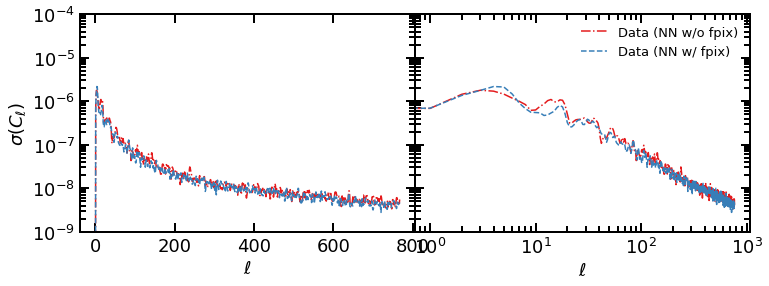

In [8]:
fg, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 4), sharey=True)
fg.subplots_adjust(wspace=0.0)

ax1.plot(np.std(cl_mitig['no weight'], axis=0), color='C1', ls='-.')
ax1.plot(np.std(cl_mitig['weighted'], axis=0), color='C2', ls='--')
ax1.set_yscale('log')
ax1.set_ylabel(r'$\sigma (C_{\ell})$')
ax1.set_xlabel(r'$\ell$')
ax1.set_ylim(1.0e-9, 1.0e-4)


ax2.plot(np.std(cl_mitig['no weight'], axis=0), color='C1', ls='-.', label='Data (NN w/o fpix)')
ax2.plot(np.std(cl_mitig['weighted'], axis=0), color='C2', ls='--', label='Data (NN w/ fpix)')
ax2.set_yscale('log')
ax2.legend()
ax2.set_xscale('log')
# ax2.ylabel(r'$\sigma (C_{\ell})$')
ax2.set_xlabel(r'$\ell$')
ax2.set_ylim(1.0e-9, 1.0e-4)

Text(0.5, 0, '$f_{{\\rm pix}, i}$')

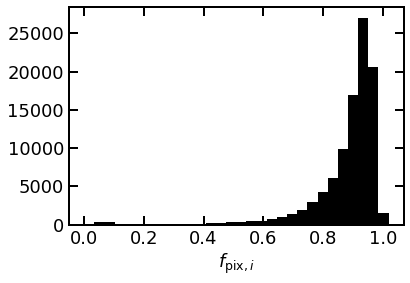

In [9]:
plt.hist(df['fracgood'], bins=30, )
plt.xlabel(r'$f_{{\rm pix}, i}$')

Based on the histogram of $f_{\rm pix}$, it seems the cost will be dominated by pixels with $f_{\rm pix} > 0.8$, and thus it makes sense that the weighted cost function does not lead any major performance difference.